In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import altair as alt
# import nltk
# from wordcloud import WordCloud, STOPWORDS
# nltk.download('stopwords')

#Merge Data: Reddit & Stock Return

## Submissions

In [0]:
meme_sub = spark.read.parquet("/FileStore/meme_stock_sub_clean")

In [0]:
meme_sub.count()

Out[103]: 380589

In [0]:
meme_sub.select('date','stock','subreddit','selftext','score','num_comments').show(10)

+----------+-----+--------------+--------------------+------+------------+
|      date|stock|     subreddit|            selftext| score|num_comments|
+----------+-----+--------------+--------------------+------+------------+
|2021-01-28|  GME|wallstreetbets|With the meme sto...|     0|          35|
|2021-01-28|  GME|wallstreetbets|Just throwing thi...|     0|          11|
|2021-01-28|  GME|           GME|I’ll take as many...|    13|           1|
|2021-01-28|  GME|wallstreetbets|LEAVE ROBINHOOD. ...|222788|       18324|
|2021-01-28|  GME|wallstreetbets|AMC, BB, and GME ...|    28|          40|
|2021-01-28|  GME|wallstreetbets|The short squeeze...|     1|           0|
|2021-01-28|  GME|           GME|Currently down 40...|    29|           2|
|2021-01-28|  GME|wallstreetbets|Buy $GME, it’s on...|    30|           0|
|2021-01-28|  GME|wallstreetbets|Can't buy or sell...|    10|           6|
|2021-01-28|  GME|wallstreetbets|GME was at $500 p...|    33|           6|
+----------+-----+-------

## Meme Stock Data

In [0]:
import pandas as pd
stock_return = sqlContext.createDataFrame(pd.read_csv('../../data/csv/meme_stock_return.csv'))

In [0]:
# convert date to datetime
stock_return = stock_return.withColumn('date',to_date(col('Date').cast('timestamp'),"yyyy-MM-dd HH:mm:ss"))
# rename column names
stock_return = stock_return.withColumn('stock', col('stock'))
stock_return = stock_return.withColumn('return', col('return'))
stock_return.printSchema()

root
 |-- date: date (nullable = true)
 |-- stock: string (nullable = true)
 |-- return: double (nullable = true)



In [0]:
stock_return.show(10)

+----------+-----+-------------------+
|      date|stock|             return|
+----------+-----+-------------------+
|2021-01-01|  AMC|-0.0863636363636365|
|2021-01-02|  AMC|-0.0863636363636365|
|2021-01-03|  AMC|-0.0863636363636365|
|2021-01-04|  AMC|-0.0863636363636365|
|2021-01-05|  AMC|-0.0050251256281407|
|2021-01-06|  AMC|-0.0098522167487684|
|2021-01-07|  AMC| -0.014423076923077|
|2021-01-08|  AMC| 0.0239234449760767|
|2021-01-09|  AMC| 0.0185185185185186|
|2021-01-10|  AMC| 0.0185185185185186|
+----------+-----+-------------------+
only showing top 10 rows



In [0]:
filename = ['AMC','BTC-USD','ETH-USD','GME']
stock = ['AMC','BTC','ETH','GME']

stock_price = pd.read_csv(f'../../data/csv/{filename[0]}.csv')
stock_price['stock'] = [filename[0][:3]]*stock_price.shape[0]
for i in range(1, len(stocks)):
    stock_price_tmp = pd.read_csv(f'../../data/csv/{filename[i]}.csv')
    stock_price_tmp['stock'] = [filename[i][:3]]*stock_price_tmp.shape[0]
    stock_price = pd.concat([stock_price,stock_price_tmp])


fig = go.Figure()

for i in range(len(stocks)):
    vis = True if stocks[i] == 'AMC' else False
    fig.add_trace(go.Candlestick(x=stock_price[stock_price.stock==stock[i]]['Date'],
                                 open=stock_price[stock_price.stock==stock[i]]['Open'], 
                                 high=stock_price[stock_price.stock==stock[i]]['High'],
                                 low=stock_price[stock_price.stock==stock[i]]['Low'], 
                                 close=stock_price[stock_price.stock==stock[i]]['Close'],
                                 visible=vis)
                         )


# add buttons to control the visibility of subplots
button1 = dict(method='update',
               args=[{"visible": [True,False,False,False]}],
               label="AMC")
button2 = dict(method='update',
               args=[{"visible": [False,True,False,False]}],
               label="BTC")
button3 = dict(method='update',
               args=[{"visible": [False,False,True,False]}],
               label="ETH")
button4 = dict(method='update',
               args=[{"visible": 3*[False] + [True]}],
               label="GME")

fig.update_layout(
    template='plotly_white',
    title="Meme Stock Historic Price",
    xaxis_title="Date",
    xaxis_rangeslider_visible=False,
    updatemenus=[dict(type='buttons',
                      buttons=[button1, button2, button3, button4],
                      direction="right",
                      xanchor="left",
                      x=0.03,
                      y=1.15,
                      yanchor="top")],
    annotations=[dict(text="Stock:", x=-0.05, xref="paper", y=1.135, yref="paper",
                      align="left", showarrow=False, font=dict(size=14.5))]
)
#fig.write_html("../../data/plots/meme_stock_historic_price.html")
fig.show()

## Merge

In [0]:
sub_merge = meme_sub.select('date','stock','subreddit','selftext','score','num_comments').join(stock_return, on=['date','stock'], how='left')
sub_merge = sub_merge.withColumn('text',col('selftext'))
sub_merge = sub_merge.drop('selftext')
sub_merge.show(10)

+----------+-----+--------------+------+------------+-------------------+--------------------+
|      date|stock|     subreddit| score|num_comments|             return|                text|
+----------+-----+--------------+------+------------+-------------------+--------------------+
|2021-01-28|  GME|wallstreetbets|     0|          35|-0.2694339320754717|With the meme sto...|
|2021-01-28|  GME|wallstreetbets|     0|          11|-0.2694339320754717|Just throwing thi...|
|2021-01-28|  GME|           GME|    13|           1|-0.2694339320754717|I’ll take as many...|
|2021-01-28|  GME|wallstreetbets|222788|       18324|-0.2694339320754717|LEAVE ROBINHOOD. ...|
|2021-01-28|  GME|wallstreetbets|    28|          40|-0.2694339320754717|AMC, BB, and GME ...|
|2021-01-28|  GME|wallstreetbets|     1|           0|-0.2694339320754717|The short squeeze...|
|2021-01-28|  GME|           GME|    29|           2|-0.2694339320754717|Currently down 40...|
|2021-01-28|  GME|wallstreetbets|    30|          

In [0]:
dis_counts = sub_merge.groupBy('date','stock','return').agg(
    count('*').alias('n_sub'),
    sum('num_comments').alias("n_com")).orderBy('date','stock').toPandas()
dis_counts['count'] = dis_counts.n_sub + dis_counts.n_com
dis_counts

,date,stock,return,n_sub,n_com,count
0,2021-01-01,BTC,0.013111,171,5107,5278
1,2021-01-01,ETH,-0.009951,39,1247,1286
2,2021-01-01,GME,-0.092105,17,6445,6462
3,2021-01-02,BTC,0.093640,325,8958,9283
4,2021-01-02,ETH,0.060422,49,1670,1719
...,...,...,...,...,...,...
2415,2022-08-30,GME,-0.056294,36,1416,1452
2416,2022-08-31,AMC,-0.049834,107,3116,3223
2417,2022-08-31,BTC,0.012636,54,3000,3054
2418,2022-08-31,ETH,0.019287,55,8602,8657


In [0]:
#dis_counts.to_csv('../../data/csv/daily_stock_discussions.csv',index=False)

In [0]:
# stock return and num discussions

stocks = ['AMC', 'BTC', 'ETH', 'GME']
stock_color = ['#b91d05', '#f2a900', '#716b94', '#fd0000']

fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

for i in range(len(stocks)):
    vis = True if stocks[i] == 'AMC' else False
    fig.add_trace(go.Bar(x=dis_counts[dis_counts.stock == stocks[i]]['date'],
                         y=dis_counts[dis_counts.stock == stocks[i]]['count'],
                         marker_color='dimgray', name='Discussion',
                         visible=vis), secondary_y=False, )
    fig.add_trace(go.Scatter(x=dis_counts[dis_counts.stock == stocks[i]]['date'],
                             y=dis_counts[dis_counts.stock ==
                                          stocks[i]]['return']*100,
                             mode='lines', visible=vis,
                             marker_color=stock_color[i], name='Return', line=dict(width=1)), secondary_y=True)


# add buttons to control the visibility of subplots
button1 = dict(method='update',
               args=[{"visible": 2*[True] + 6*[False]}],
               label="AMC")
button2 = dict(method='update',
               args=[{"visible": 2*[False] + 2*[True] + 4*[False]}],
               label="BTC")
button3 = dict(method='update',
               args=[{"visible": 4*[False] + 2*[True] + 2*[False]}],
               label="ETH")
button4 = dict(method='update',
               args=[{"visible": 6*[False] + 2*[True]}],
               label="GME")

fig.update_layout(
    template='plotly_white',
    title="Meme Stock Return vs Reddit Discussion",
    xaxis_title="Date",
    updatemenus=[dict(type='buttons',
                      buttons=[button1, button2, button3, button4],
                      direction="right",
                      xanchor="left",
                      x=0.03,
                      y=1.15,
                      yanchor="top")],
    annotations=[dict(text="Stock:", x=-0.05, xref="paper", y=1.135, yref="paper",
                      align="left", showarrow=False, font=dict(size=14.5))]
)
fig.update_yaxes(title_text="Number of discussions", secondary_y=False)
fig.update_yaxes(title_text="Stock return (%)", secondary_y=True)
#fig.write_html("../../data/plots/meme_stock_return_vs_discussion.html")
fig.show()


# Text Cleaning

In [0]:
# remove emojis and unsual characters
sub_merge = sub_merge.withColumn("text", regexp_replace("text", "[^\x00-\x7F]+|[$%@#]", ""))
sub_merge.show(10)

+----------+-----+--------------+------+------------+-------------------+--------------------+
|      date|stock|     subreddit| score|num_comments|             return|                text|
+----------+-----+--------------+------+------------+-------------------+--------------------+
|2021-01-28|  GME|wallstreetbets|     0|          35|-0.2694339320754717|With the meme sto...|
|2021-01-28|  GME|wallstreetbets|     0|          11|-0.2694339320754717|Just throwing thi...|
|2021-01-28|  GME|           GME|    13|           1|-0.2694339320754717|Ill take as many ...|
|2021-01-28|  GME|wallstreetbets|222788|       18324|-0.2694339320754717|LEAVE ROBINHOOD. ...|
|2021-01-28|  GME|wallstreetbets|    28|          40|-0.2694339320754717|AMC, BB, and GME ...|
|2021-01-28|  GME|wallstreetbets|     1|           0|-0.2694339320754717|The short squeeze...|
|2021-01-28|  GME|           GME|    29|           2|-0.2694339320754717|Currently down 40...|
|2021-01-28|  GME|wallstreetbets|    30|          

In [0]:
# remove urls
sub_merge = sub_merge.withColumn("text", regexp_replace("text", "https?:\S+|www\.\S+", ""))
sub_merge.show(10)

+----------+-----+--------------+------+------------+-------------------+--------------------+
|      date|stock|     subreddit| score|num_comments|             return|                text|
+----------+-----+--------------+------+------------+-------------------+--------------------+
|2021-01-28|  GME|wallstreetbets|     0|          35|-0.2694339320754717|With the meme sto...|
|2021-01-28|  GME|wallstreetbets|     0|          11|-0.2694339320754717|Just throwing thi...|
|2021-01-28|  GME|           GME|    13|           1|-0.2694339320754717|Ill take as many ...|
|2021-01-28|  GME|wallstreetbets|222788|       18324|-0.2694339320754717|LEAVE ROBINHOOD. ...|
|2021-01-28|  GME|wallstreetbets|    28|          40|-0.2694339320754717|AMC, BB, and GME ...|
|2021-01-28|  GME|wallstreetbets|     1|           0|-0.2694339320754717|The short squeeze...|
|2021-01-28|  GME|           GME|    29|           2|-0.2694339320754717|Currently down 40...|
|2021-01-28|  GME|wallstreetbets|    30|          

In [0]:
# if submission contains stock name
sub_merge = sub_merge.withColumn('if_name',col('text').rlike(
    '(?i)gme|(?i)gamestop|(?i)btc|(?i)bitcoin|(?i)eth|(?i)ethereum|(?i)amc|(?i)american multi-cinema|(?i)american multicinema'))
# if submission contains number
sub_merge = sub_merge.withColumn('if_number',col('text').rlike('\d+'))
sub_merge.show(10)

+----------+-----+--------------+------+------------+-------------------+--------------------+-------+---------+
|      date|stock|     subreddit| score|num_comments|             return|                text|if_name|if_number|
+----------+-----+--------------+------+------------+-------------------+--------------------+-------+---------+
|2021-01-28|  GME|wallstreetbets|     0|          35|-0.2694339320754717|With the meme sto...|   true|     true|
|2021-01-28|  GME|wallstreetbets|     0|          11|-0.2694339320754717|Just throwing thi...|   true|     true|
|2021-01-28|  GME|           GME|    13|           1|-0.2694339320754717|Ill take as many ...|  false|    false|
|2021-01-28|  GME|wallstreetbets|222788|       18324|-0.2694339320754717|LEAVE ROBINHOOD. ...|   true|    false|
|2021-01-28|  GME|wallstreetbets|    28|          40|-0.2694339320754717|AMC, BB, and GME ...|   true|    false|
|2021-01-28|  GME|wallstreetbets|     1|           0|-0.2694339320754717|The short squeeze...|  

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentences')

tokenizer = Tokenizer() \
    .setInputCols(["sentences"]) \
    .setOutputCol("token")

spellModel = ContextSpellCheckerModel\
    .pretrained('spellcheck_dl','en')\
    .setInputCols("token")\
    .setOutputCol("checked")\
    .setErrorThreshold(4.0)\
    .setTradeoff(6.0)

normalizer = Normalizer() \
    .setInputCols(["checked"]) \
    .setOutputCol("normalized")\
    .setLowercase(True)\
    #.setCleanupPatterns(["""[^\w\d\s]"""])

stopwords_cleaner = StopWordsCleaner()\
    .setInputCols("normalized")\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)\

lemmatizer = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma")

wordEmbedding = WordEmbeddingsModel.pretrained() \
    .setInputCols(["document", "lemma"]) \
    .setOutputCol("word_embeddings") \
    .setCaseSensitive(False)

sentenceEmbedding = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
    .setInputCols(["document", "word_embeddings"])\
    .setOutputCol("sentence_embeddings")
 
sentimentModel = SentimentDLModel.pretrained(name="sentimentdl_use_twitter", lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(stages=[documentAssembler,
                               sentenceDetector,
                               tokenizer,
                               spellModel,
                              normalizer,
                              stopwords_cleaner,
                              lemmatizer,
                              wordEmbedding,
                              sentenceEmbedding,
                              sentimentModel])

empty_df = spark.createDataFrame([[""]]).toDF("text")
merge_clean = nlpPipeline.fit(empty_df).transform(sub_merge)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [0]:
merged = merge_clean.select(
    'date','stock','subreddit','score','num_comments','return',
    'if_name','if_number',
    'text',
    col('lemma.result').alias('lemma'),
    explode('sentiment.result').alias('sentiment')
)
merged.show(10)

+----------+-----+--------------+------+------------+-------------------+-------+---------+--------------------+--------------------+---------+
|      date|stock|     subreddit| score|num_comments|             return|if_name|if_number|                text|               lemma|sentiment|
+----------+-----+--------------+------+------------+-------------------+-------+---------+--------------------+--------------------+---------+
|2021-01-28|  GME|wallstreetbets|     0|          35|-0.2694339320754717|   true|     true|With the meme sto...|[meme, stock, mee...| negative|
|2021-01-28|  GME|wallstreetbets|     0|          11|-0.2694339320754717|   true|     true|Just throwing thi...|[throw, possibili...| negative|
|2021-01-28|  GME|           GME|    13|           1|-0.2694339320754717|  false|    false|Ill take as many ...|[ill, take, many,...| positive|
|2021-01-28|  GME|wallstreetbets|222788|       18324|-0.2694339320754717|   true|    false|LEAVE ROBINHOOD. ...|[leave, robinhood...| po

In [0]:
#merged.write.mode("overwrite").format('parquet').save("/FileStore/meme_clean_sentiment")

# Basic Text Analysis

In [0]:
merged = spark.read.parquet("/FileStore/meme_clean_sentiment")

## Stock Name Mentions

In [0]:
name_mention = merged.groupBy('stock','if_name').count().orderBy('stock','if_name').toPandas()
name_mention['if_name'] = name_mention['if_name'].map({True:'Mentioned',False:'Not mentioned'})
name_mention = name_mention.pivot(index='stock',columns='if_name',values='count').reset_index()
#name_mention.to_csv('../../data/csv/name_mentions.csv',index=False)
name_mention

if_name,stock,Mentioned,Not mentioned
0,AMC,35552,79769
1,BTC,76476,15782
2,ETH,44770,3736
3,GME,66117,53767


## Number Mentions

In [0]:
number_mention = merged.groupBy('stock','if_number').count().orderBy('stock','if_number').toPandas()
number_mention['if_number'] = number_mention['if_number'].map({True:'Mentioned',False:'Not mentioned'})
number_mention = number_mention.pivot(index='stock',columns='if_number',values='count').reset_index()
#number_mention.to_csv('../../data/csv/number_mentions.csv',index=False)
number_mention

if_number,stock,Mentioned,Not mentioned
0,AMC,47561,67760
1,BTC,59840,32418
2,ETH,34359,14147
3,GME,67245,52639


In [0]:
fig = make_subplots(rows=1, cols=2,
subplot_titles=("Stock Name Mentions", "Numbers Mentions"))

fig.add_trace(go.Bar(
    x=name_mention["stock"],
        y=name_mention["Mentioned"],
        offsetgroup=0,
        marker_color = "rgba(255, 0, 0, 0.6)", 
        name='Mentioned'),row=1,col=1)
fig.add_trace(go.Bar(
    x=name_mention["stock"],
        y=name_mention["Not mentioned"],
        offsetgroup=0,
        base=name_mention["Mentioned"],
        marker_color = '#1f77b4', 
        name='Notentioned'),row=1,col=1)

fig.add_trace(go.Bar(
    x=number_mention["stock"],
        y=number_mention["Mentioned"],
        offsetgroup=0,
        marker_color = "rgba(255, 0, 0, 0.6)", 
        showlegend=False,
        name='Mentioned'),row=1,col=2)
fig.add_trace(go.Bar(
    x=number_mention["stock"],
        y=number_mention["Not mentioned"],
        offsetgroup=0,
        base=number_mention["Mentioned"],
        marker_color = '#1f77b4', 
        showlegend=False,
        name='Not mentioned'),row=1,col=2)
fig.update_layout(template='plotly_white',
                 title='Number of Submissions with Specific Contents')
#fig.write_html("../../data/plots/num_mentions.html")
fig.show()

## Most Common Words

In [0]:
# overall word count
overall_wc = merged.withColumn('word',explode('lemma'))\
.groupBy('word').count()\
.orderBy('count', ascending=False).filter(~col('word').isin('amp','ill','im','xb'))
overall_wc.show()

+------+------+
|  word| count|
+------+------+
| share|254337|
|   get|250926|
|    go|249407|
|   buy|225922|
|  like|209277|
| price|204965|
|  make|195165|
|market|187999|
|   see|184354|
|  know|177497|
| stock|173323|
|  time|166920|
|   one|159577|
|  dont|155872|
|  sell|152332|
|   use|151888|
|people|150588|
| think|148756|
| short|147785|
| money|132501|
+------+------+
only showing top 20 rows



In [0]:
from pyspark.sql.window import Window

by_stock_wc = merged.withColumn('word',explode('lemma'))\
  .filter(~col("word").isin('amp','ill','im','xb'))\
  .groupBy('stock','word').count()

windowStock = Window.partitionBy("stock").orderBy(col("count").desc())
top_wc_by_stock = by_stock_wc.withColumn("row",row_number().over(windowStock))\
  .filter(col("row") <= 100)\
  .drop("row").toPandas()

In [0]:
top_wc_by_stock[top_wc_by_stock.stock=='AMC'].sort_values("count",ascending=False).head(10)

,stock,word,count
200,AMC,share,59776
201,AMC,ape,54720
202,AMC,amc,47957
203,AMC,buy,44407
204,AMC,go,42901
205,AMC,get,42568
206,AMC,stock,31896
207,AMC,know,31005
208,AMC,see,30000
209,AMC,hold,29742


In [0]:
top_wc_by_stock[top_wc_by_stock.stock=='BTC'].sort_values("count",ascending=False).head(10)

,stock,word,count
300,BTC,bitcoin,126116
301,BTC,crypto,80566
302,BTC,btc,70998
303,BTC,get,60538
304,BTC,like,57276
305,BTC,use,56822
306,BTC,go,56146
307,BTC,coin,54773
308,BTC,buy,54512
309,BTC,make,50556


In [0]:
top_wc_by_stock[top_wc_by_stock.stock=='ETH'].sort_values("count",ascending=False).head(10)

,stock,word,count
0,ETH,get,44845
1,ETH,like,41253
2,ETH,go,40125
3,ETH,crypto,37438
4,ETH,make,37410
5,ETH,use,37028
6,ETH,market,34130
7,ETH,see,31550
8,ETH,one,31360
9,ETH,time,30315


In [0]:
top_wc_by_stock[top_wc_by_stock.stock=='GME'].sort_values("count",ascending=False).head(10)

,stock,word,count
100,GME,share,166091
101,GME,gme,124580
102,GME,short,111696
103,GME,go,110235
104,GME,stock,107589
105,GME,get,102975
106,GME,price,101249
107,GME,buy,98161
108,GME,market,84490
109,GME,like,83067


In [0]:
# top_wc_by_stock.sort_values(['stock','count'],
#                             ascending=[True,False]).to_csv('../../data/csv/top100_words_per_stock.csv',index=False)

In [0]:
common_words = pd.read_csv("../../data/csv/top100_words_per_stock.csv")

fig = make_subplots(rows=2, cols=2,
subplot_titles=("AMC","BTC","ETH","GME"))
stocks = ['AMC', 'BTC', 'ETH', 'GME']
stock_color = ['#b91d05', '#f2a900', '#716b94', '#fd0000']

for i, stock in enumerate(["AMC","BTC","ETH","GME"]):
    fig.add_trace(go.Bar(
        x=common_words[common_words.stock==stock]["word"].iloc[0:10],
            y=common_words[common_words.stock==stock]["count"].iloc[0:10],
            marker_color = stock_color[i],
            showlegend=False,
            name=stock),row=i//2+1,col=i%2+1)
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=2, col=1)
fig.update_layout(template='plotly_white',
                 title='Top 10 Most Common Words of Meme Stock Submissions')
#fig.write_html("../../data/plots/common_words.html")
fig.show()

## Length Distribution

In [0]:
merged = merged.withColumn("full_length", size(split('text',' ')))
merged = merged.withColumn('meaningful_length', size('lemma'))
merged = merged.withColumn('meaningful_fraction', col('meaningful_length')/col('full_length'))
merged.select('full_length','meaningful_length','meaningful_fraction').show(10)

+-----------+-----------------+-------------------+
|full_length|meaningful_length|meaningful_fraction|
+-----------+-----------------+-------------------+
|         12|                9|               0.75|
|         45|               28| 0.6222222222222222|
|         91|               48| 0.5274725274725275|
|         37|               23| 0.6216216216216216|
|        240|              119|0.49583333333333335|
|         14|               10| 0.7142857142857143|
|        227|              106| 0.4669603524229075|
|        251|              125|0.49800796812749004|
|          8|                4|                0.5|
|         87|               43| 0.4942528735632184|
+-----------+-----------------+-------------------+
only showing top 10 rows



In [0]:
length_summary = merged.select("stock",'full_length','meaningful_length','meaningful_fraction')\
    .melt(ids='stock', values=['full_length','meaningful_length','meaningful_fraction'],
          variableColumnName='text_type',valueColumnName='value')\
    .groupBy('text_type')\
    .agg(round(avg('value'),1).alias('mean'),
         min('value').alias('min'),
         expr("round(percentile(value,0.25),1)").alias("Q25"),
         expr("round(percentile(value,0.5),1)").alias("median"),
         expr("round(percentile(value,0.75),1)").alias("Q75"),
         max('value').alias('max'))
length_summary.toPandas()

,text_type,mean,min,Q25,median,Q75,max
0,meaningful_length,94.0,0.0,13.0,36.0,86.0,10767.000
1,full_length,179.7,1.0,25.0,71.0,168.0,19431.000
2,meaningful_fraction,0.5,0.0,0.5,0.5,0.6,42.875


In [0]:
#length_summary.toPandas().to_csv('../../data/csv/text_length_summary.csv',index=False)

In [0]:
full_length_count = merged.groupBy('full_length').count().orderBy(desc('count'))
full_length_count.show()

+-----------+-----+
|full_length|count|
+-----------+-----+
|          1|10501|
|          2| 4994|
|          4| 4846|
|          3| 4743|
|          5| 4558|
|          6| 4230|
|          7| 4214|
|          8| 3939|
|          9| 3772|
|         11| 3675|
|         10| 3665|
|         12| 3476|
|         13| 3396|
|         14| 3373|
|         15| 3307|
|         16| 3220|
|         17| 3185|
|         18| 3067|
|         19| 3009|
|         21| 2971|
+-----------+-----+
only showing top 20 rows



In [0]:
meaningful_length_count = merged.groupBy('meaningful_length').count().orderBy(desc('count'))
meaningful_length_count.show()

+-----------------+-----+
|meaningful_length|count|
+-----------------+-----+
|                2|11801|
|                3| 9450|
|                4| 7787|
|                5| 7476|
|                6| 7126|
|                7| 6778|
|                8| 6670|
|                1| 6562|
|                9| 6113|
|               10| 5948|
|               11| 5699|
|                0| 5655|
|               12| 5479|
|               13| 5444|
|               14| 5220|
|               15| 4938|
|               16| 4921|
|               18| 4743|
|               17| 4708|
|               19| 4502|
+-----------------+-----+
only showing top 20 rows



In [0]:
# full_length_count.toPandas().to_csv("../../data/csv/full_length_count.csv",index=False)
# meaningful_length_count.toPandas().to_csv("../../data/csv/meaningful_length_count.csv",index=False)

In [0]:
# length distribution
full_length = pd.read_csv('../../data/csv/full_length_count.csv').sort_values('full_length')
meaningful_length = pd.read_csv('../../data/csv/meaningful_length_count.csv').sort_values('meaningful_length')

# full length upper bound = Q3+1.5*IQR = 382.5
full_clean = full_length[full_length.full_length<=382.5]
# meaningful length upper bound = Q3+1.5*IQR = 195.5
meaningful_clean = meaningful_length[meaningful_length.meaningful_length<=195.5]

fig = make_subplots(rows=2, cols=1,
                subplot_titles=("Text Length","Text Length w/o Outliers"))

fig.add_trace(go.Scatter(x=full_length['full_length'],
    y=full_length['count'],
    mode='lines',
    line_shape='spline',
    name='Full text'), row=1, col=1)
fig.add_trace(go.Scatter(x=meaningful_length['meaningful_length'],
    y=meaningful_length['count'],
    mode='lines',
    line_shape='spline',
    name='Meaningful text'), row=1, col=1)

fig.add_trace(go.Scatter(x=full_clean['full_length'],
    y=full_clean['count'],
    mode='lines',
    line_shape='spline',
    name='Full text cleaned'), row=2, col=1)

fig.add_trace(go.Scatter(x=meaningful_clean['meaningful_length'],
    y=meaningful_clean['count'],
    mode='lines',
    line_shape='spline',
    name='Meaningful text cleaned'), row=2, col=1)

fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=2, col=1)
fig.update_xaxes(title_text="Length (#words)", row=1, col=1)
fig.update_xaxes(title_text="Length (#words)", row=2, col=1)

fig.update_layout(template='plotly_white',
                    width=800, height=550,
                 title='Text Length Distribution')
#fig.write_html("../../data/plots/text_length.html")
fig.show()

## Important Words (TF-IDF)

In [0]:
from pyspark.ml.feature import HashingTF, IDF

TF = HashingTF(inputCol="lemma", outputCol="rawFeatures", numFeatures=2048)
featurized = TF.transform(merged)
idf = IDF(inputCol="rawFeatures", outputCol="features")
tf_idf = idf.fit(featurized).transform(featurized)

tf_idf.printSchema()


root
 |-- date: date (nullable = true)
 |-- stock: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- score: long (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- return: double (nullable = true)
 |-- if_name: boolean (nullable = true)
 |-- if_number: boolean (nullable = true)
 |-- text: string (nullable = true)
 |-- lemma: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sentiment: string (nullable = true)
 |-- full_length: integer (nullable = false)
 |-- meaningful_length: integer (nullable = false)
 |-- meaningful_fraction: double (nullable = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)



In [0]:
from pyspark.sql.types import *

def to_array_(v):
    return v.values.tolist()
to_array = udf(lambda z: to_array_(z),ArrayType(FloatType()))

tf_idf = tf_idf.withColumn("fea_arr",to_array(col("features")))

In [0]:
tfidf_long = tf_idf.withColumn("new", arrays_zip("lemma", "fea_arr"))\
       .withColumn("new", explode("new"))\
       .select("stock", col("new.lemma").alias("word"), col("new.fea_arr").alias("tfidf"))
tfidf_long.show()

+-----+--------------+---------+
|stock|          word|    tfidf|
+-----+--------------+---------+
|  AMC|          know|1.4677708|
|  AMC|           ape|2.8139517|
|  AMC|          sell|1.7914032|
|  AMC|          what|3.3690314|
|  AMC|           amc|2.0705497|
|  AMC|          hold|2.4474695|
|  AMC|      positive|1.3314242|
|  AMC|      negative|1.6116613|
|  AMC|           atm| 2.996717|
|  GME|         stock|2.1707542|
|  GME|      dividend| 2.944838|
|  GME|           set|1.6478281|
|  GME|recommendation| 3.620099|
|  GME|      question|5.0346465|
|  GME|            cs| 3.544331|
|  GME|          seem|1.8884777|
|  GME|          easy| 2.796235|
|  GME|           tda| 4.122205|
|  GME|          ibkr| 4.603496|
|  GME|         other|2.9833875|
+-----+--------------+---------+
only showing top 20 rows



In [0]:
tfidf_long.count()

Out[61]: 35332571

In [0]:
# overall important words by tfidf
overall_tfidf = tfidf_long.filter(~col('word').isin('amp','ill','im','xb'))\
    .groupBy('word')\
    .agg(sum("tfidf").alias("tfidf"))\
    .orderBy(desc("tfidf"))
overall_tfidf.limit(20).toPandas()

,word,tfidf
0,get,693972.486510
1,share,688787.955587
2,go,675495.554347
3,buy,598097.725189
4,like,573915.713055
5,price,558687.662474
6,market,549106.546325
7,make,542732.443224
8,see,513582.887317
9,know,483480.232500


In [0]:
overall_tfidf.count()

Out[66]: 278969

In [0]:
by_stock_tfidf = tfidf_long.filter(~col("word").isin('amp','ill','im','xb'))\
  .groupBy('stock','word')\
  .agg(sum('tfidf').alias('tfidf'))

windowStock = Window.partitionBy("stock").orderBy(col("tfidf").desc())
top_tfidf_by_stock = by_stock_tfidf.withColumn("row",row_number().over(windowStock))\
  .filter(col("row") <= 100)\
  .drop("row").toPandas()

In [0]:
#AMC
top_tfidf_by_stock[top_tfidf_by_stock.stock=='AMC'].sort_values("tfidf",ascending=False).head(10)

,stock,word,tfidf
200,AMC,share,161606.076391
201,AMC,ape,136565.471025
202,AMC,amc,134646.206191
203,AMC,get,115184.778147
204,AMC,go,113134.320772
205,AMC,buy,110471.697715
206,AMC,stock,88106.694448
207,AMC,know,83784.496320
208,AMC,see,80812.344072
209,AMC,price,79724.513171


In [0]:
#BTC
top_tfidf_by_stock[top_tfidf_by_stock.stock=='BTC'].sort_values("tfidf",ascending=False).head(10)

,stock,word,tfidf
300,BTC,bitcoin,378897.300059
301,BTC,crypto,235383.523758
302,BTC,btc,198955.011647
303,BTC,get,166350.088107
304,BTC,use,161165.264892
305,BTC,like,158247.901597
306,BTC,coin,157958.850662
307,BTC,go,149418.401022
308,BTC,buy,148675.397336
309,BTC,make,139010.918977


In [0]:
top_tfidf_by_stock[top_tfidf_by_stock.stock=='ETH'].sort_values("tfidf",ascending=False).head(10)

,stock,word,tfidf
0,ETH,get,128478.591075
1,ETH,like,116351.210090
2,ETH,use,110337.829594
3,ETH,go,109695.526294
4,ETH,crypto,108123.527929
5,ETH,market,106396.692165
6,ETH,make,104711.916497
7,ETH,one,92560.141545
8,ETH,see,91815.284022
9,ETH,time,83841.633548


In [0]:
top_tfidf_by_stock[top_tfidf_by_stock.stock=='GME'].sort_values("tfidf",ascending=False).head(10)

,stock,word,tfidf
100,GME,share,452059.770176
101,GME,gme,352070.163252
102,GME,short,326807.514823
103,GME,go,303247.306260
104,GME,stock,300057.606086
105,GME,get,283959.029181
106,GME,price,274925.569103
107,GME,buy,258007.790303
108,GME,market,247024.909043
109,GME,like,225273.936035


In [0]:
# top_tfidf_by_stock.sort_values(['stock','tfidf'],
#                              ascending=[True,False]).to_csv('../../data/csv/top100_tfidf_per_stock.csv',index=False)

In [0]:
tfidf = pd.read_csv('../../data/csv/top100_tfidf_per_stock.csv')
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("AMC","BTC","ETH","GME"))
stocks = ['AMC', 'BTC', 'ETH', 'GME']
stock_color = ['#b91d05', '#f2a900', '#716b94', '#fd0000']

for i, stock in enumerate(["AMC","BTC","ETH","GME"]):
    fig.add_trace(go.Bar(
        x=tfidf[tfidf.stock==stock]["word"].iloc[0:10],
            y=tfidf[tfidf.stock==stock]["tfidf"].iloc[0:10],
            marker_color = stock_color[i],
            showlegend=False,
            name=stock),row=i//2+1,col=i%2+1)

fig.update_yaxes(title_text="TFIDF", row=1, col=1)
fig.update_yaxes(title_text="TFIDF", row=2, col=1)

fig.update_layout(template='plotly_white',
                 title='Top 10 Most Important Words (TFIDF) of Meme Stock Submissions')
#fig.write_html("../../data/plots/tfidf_important_words.html")
fig.show()

# Sentiment Analysis

## Overall Sentiment

In [0]:
# overall sentiment distribution
overall_senti = merged.groupBy('sentiment').count().toPandas()
overall_senti['percentage'] = overall_senti['count'] / overall_senti['count'].sum()
#overall_senti.to_csv('../../data/csv/overall_sentiment.csv',index=False)
overall_senti

,sentiment,count,percentage
0,positive,225295,0.599238
1,neutral,15628,0.041567
2,negative,135046,0.359195


In [0]:
fig = make_subplots(rows=1, cols=2,specs=[[{"type": "bar"}, {"type": "pie"}]])

fig.add_trace(go.Bar(x=overall_senti['sentiment'],
                    y=overall_senti['count'],
                    text=overall_senti['count'],
                    marker_color=['#30ba30','gold','#ff4040'],
                    showlegend=False,
                    name='Count'), row=1, col=1)

fig.add_trace(go.Pie(labels=overall_senti['sentiment'],
                    values=overall_senti['count'],
                    text=overall_senti['count'],
                    pull=[0.05, 0.05, 0.05],
                    marker_colors=['#30ba30','gold','#ff4040'],
                    name='Percentage'), row=1, col=2)

fig.update_yaxes(title_text="Number of submission", row=1, col=1)
fig.update_layout(template='plotly_white',
                title='Overall Sentiment of Meme Stock Submissions')
#fig.write_html("../../data/plots/overall_sentiment.html")
fig.show()

## Subreddit Sentiment

In [0]:
# sentiment distribution by subreddit
subreddit_senti = merged.groupBy('subreddit','sentiment').count().orderBy('subreddit','sentiment').toPandas()
subreddit_senti['percentage'] = subreddit_senti['count'] / subreddit_senti.groupby(['subreddit'])['count'].transform('sum')
subreddit_senti.pivot(index='subreddit',columns='sentiment',values='count').reset_index()

sentiment,subreddit,negative,neutral,positive
0,Bitcoin,18821,1171,30022
1,CryptoCurrency,17832,1772,53827
2,GME,34238,4647,54066
3,StockMarket,1237,58,1896
4,amcstock,48133,6801,65894
5,ethereum,3961,141,6475
6,investing,844,57,1412
7,wallstreetbets,9980,981,11703


In [0]:
# subreddit_senti.pivot(index='subreddit',columns='sentiment',values='count').reset_index()\
#     .to_csv('../../data/csv/subreddit_sentiment_count.csv',index=False)

In [0]:
# percentage
subreddit_senti.pivot(index='subreddit',columns='sentiment',values='percentage').reset_index()

sentiment,subreddit,negative,neutral,positive
0,Bitcoin,0.376315,0.023413,0.600272
1,CryptoCurrency,0.242840,0.024131,0.733028
2,GME,0.368345,0.049994,0.581661
3,StockMarket,0.387653,0.018176,0.594171
4,amcstock,0.398360,0.056287,0.545354
5,ethereum,0.374492,0.013331,0.612177
6,investing,0.364894,0.024643,0.610463
7,wallstreetbets,0.440346,0.043285,0.516370


In [0]:
# subreddit_senti.pivot(index='subreddit',columns='sentiment',values='percentage').reset_index()\
#      .to_csv('../../data/csv/subreddit_sentiment_percent.csv',index=False)

## Stock Sentiment

In [0]:
# sentiment distribution by stock
stock_senti = merged.groupBy('stock','sentiment').count().orderBy('stock','sentiment').toPandas()
stock_senti['percentage'] = stock_senti['count'] / stock_senti.groupby(['stock'])['count'].transform('sum')
# stock_senti.to_csv('../../data/csv/stock_sentiment.csv',index=False)
stock_senti.pivot(index='stock',columns='sentiment',values='count').reset_index()

sentiment,stock,negative,neutral,positive
0,AMC,45601,6479,63241
1,BTC,27510,2201,62547
2,ETH,16196,1062,31248
3,GME,45739,5886,68259


In [0]:
# stock_senti.pivot(index='stock',columns='sentiment',values='count').reset_index()\
#     .to_csv('../../data/csv/stock_sentiment_count.csv',index=False)

In [0]:
# stock_senti.pivot(index='stock',columns='sentiment',values='percentage').reset_index()\
#      .to_csv('../../data/csv/stock_sentiment_percentage.csv',index=False)
stock_senti.pivot(index='stock',columns='sentiment',values='percentage').reset_index()

sentiment,stock,negative,neutral,positive
0,AMC,0.395427,0.056182,0.548391
1,BTC,0.298186,0.023857,0.677957
2,ETH,0.333897,0.021894,0.644209
3,GME,0.381527,0.049097,0.569375


## Daily Stock Sentiment

In [0]:
# daily sentiment
daily_senti = merged.groupBy('stock','date','return','sentiment').count()\
    .orderBy('stock','date','sentiment').toPandas()
#daily_senti.to_csv('../../data/csv/daily_stock_sentiment.csv',index=False)
daily_senti

,stock,date,return,sentiment,count
0,AMC,2021-01-06,-0.009852,negative,1
1,AMC,2021-01-06,-0.009852,positive,1
2,AMC,2021-01-07,-0.014423,positive,1
3,AMC,2021-01-08,0.023923,negative,1
4,AMC,2021-01-12,0.022321,positive,1
...,...,...,...,...,...
6851,GME,2022-08-30,-0.056294,neutral,4
6852,GME,2022-08-30,-0.056294,positive,19
6853,GME,2022-08-31,-0.013214,negative,29
6854,GME,2022-08-31,-0.013214,neutral,3


In [0]:
stocks = ['AMC', 'BTC', 'ETH', 'GME']
stock_color = ['#b91d05', '#f2a900', '#716b94', '#fd0000']

fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])

for i in range(len(stocks)):
    vis = True if stocks[i] == 'AMC' else False
    # positive sentiment
    fig.add_trace(go.Scatter(
        x=daily_senti[(daily_senti.stock == stocks[i])&(daily_senti.sentiment == 'positive')]['date'],
        y=daily_senti[(daily_senti.stock == stocks[i])&(daily_senti.sentiment == 'positive')]['count'],
        marker_color='#30ba30', name='Positive',visible=vis,line=dict(width=1)), secondary_y=False)
    # negative sentiment
    fig.add_trace(go.Scatter(
        x=daily_senti[(daily_senti.stock == stocks[i])&(daily_senti.sentiment == 'negative')]['date'],
        y=daily_senti[(daily_senti.stock == stocks[i])&(daily_senti.sentiment == 'negative')]['count'],
        marker_color='salmon', name='Negative',visible=vis,line=dict(width=1)), secondary_y=False)
    # stock return
    fig.add_trace(go.Scatter(x=daily_senti[daily_senti.stock == stocks[i]]['date'],
                             y=daily_senti[daily_senti.stock ==stocks[i]]['return']*100,
                             mode='lines', visible=vis, marker_color=stock_color[i], 
                             name=f'{stocks[i]} Return', line=dict(width=1.5)), secondary_y=True)

# add buttons to control the visibility of subplots
button1 = dict(method='update',
               args=[{"visible": 3*[True] + 9*[False]}],
               label="AMC")
button2 = dict(method='update',
               args=[{"visible": 3*[False] + 3*[True] + 6*[False]}],
               label="BTC")
button3 = dict(method='update',
               args=[{"visible": 6*[False] + 3*[True] + 3*[False]}],
               label="ETH")
button4 = dict(method='update',
               args=[{"visible": 9*[False] + 3*[True]}],
               label="GME")

fig.update_layout(
    template='plotly_white',
    title="Meme Stock Return vs Sentiment",
    xaxis_title="Date",
    updatemenus=[dict(type='buttons',
                      buttons=[button1, button2, button3, button4],
                      direction="right",
                      xanchor="left",
                      x=0.03,
                      y=1.15,
                      yanchor="top")],
    annotations=[dict(text="Stock:", x=-0.05, xref="paper", y=1.135, yref="paper",
                      align="left", showarrow=False, font=dict(size=14.5))]
)
fig.update_yaxes(title_text="Number of submissions", secondary_y=False)
fig.update_yaxes(title_text="Stock return (%)", secondary_y=True)
#fig.write_html("../../data/plots/meme_stock_return_vs_sentiments.html")
fig.show()



## Top Words by Sentiment

### Word Count

In [0]:
# positive sentiment wordcount
pos_wc = merged.filter(col('sentiment')=='positive')\
    .withColumn('word',explode('lemma'))\
    .groupBy('word').count()\
    .orderBy('count', ascending=False).filter(~col('word').isin('amp','ill','im','xb')).limit(1000).toPandas()
#pos_wc.to_csv('../../data/csv/postive_words.csv',index=False)

In [0]:
# neutral sentiment wordcount
neu_wc = merged.filter(col('sentiment')=='neutral')\
    .withColumn('word',explode('lemma'))\
    .groupBy('word').count()\
    .orderBy('count', ascending=False).filter(~col('word').isin('amp','ill','im','xb')).limit(1000).toPandas()
#neu_wc.to_csv('../../data/csv/neutral_words.csv',index=False)

In [0]:
# negative sentiment wordcount
neg_wc = merged.filter(col('sentiment')=='negative')\
    .withColumn('word',explode('lemma'))\
    .groupBy('word').count()\
    .orderBy('count', ascending=False).filter(~col('word').isin('amp','ill','im','xb')).limit(1000).toPandas()
#neg_wc.to_csv('../../data/csv/negative_words.csv',index=False)

In [0]:
brush = alt.selection_multi(encodings=['y'])

# positive
pos_bar = alt.Chart(pos_wc.head(25)).mark_bar().encode(
    y=alt.Y('word:N', title='Word', sort='-x'),
    x=alt.X('count:Q', title='Count'),
    color=alt.condition(brush, alt.value('#30ba30'), alt.value('lightgray'))
)

pos_text = pos_bar.mark_text(
    align='left',
    baseline='middle',
    dx=3,
    y=-0.1
).encode(text='count:Q',
         color=alt.value('gray')
)

pos_chart = (pos_bar + pos_text).properties(
    title=alt.TitleParams(text='Positive', fontSize=13),
    width=290,
    height=300
).add_selection(
    brush
)

# negative
neg_bar = alt.Chart(neg_wc.head(25)).mark_bar().encode(
    y=alt.Y('word:N', title='Word', sort='-x'),
    x=alt.X('count:Q', title='Count'),
    color=alt.condition(brush, alt.value('#ff4040'), alt.value('lightgray'))
)

neg_text = neg_bar.mark_text(
    align='left',
    baseline='middle',
    dx=3,
    y=-0.1
).encode(text='count:Q',
         color=alt.value('gray')
)

neg_chart = (neg_bar + neg_text).properties(
    title=alt.TitleParams(text='Negative', fontSize=13),
    width=290,
    height=300
).add_selection(
    brush
)

# neutral
neu_bar = alt.Chart(neu_wc.head(25)).mark_bar().encode(
    y=alt.Y('word:N', title='Word', sort='-x'),
    x=alt.X('count:Q', title='Count'),
    color=alt.condition(brush, alt.value('gold'), alt.value('lightgray'))
)

neu_text = neu_bar.mark_text(
    align='left',
    baseline='middle',
    dx=3,
    y=-0.1
).encode(text='count:Q',
         color=alt.value('gray')
)

neu_chart = (neu_bar + neu_text).properties(
    title=alt.TitleParams(text='Neutral', fontSize=13),
    width=290,
    height=300
).add_selection(
    brush
)

chart = (pos_chart | neu_chart | neg_chart).properties(
    title='Top 25 Frequently Used Words in Submissions by Sentiment'
).configure_title(
    fontSize=16,
    anchor='middle'
)

#chart.save('../../data/plots/top25_words_by_sentiment.html')

chart

### Frequent Words of Top-scored Submissions

In [0]:
pos10000 = merged.filter(col("sentiment") == "positive")\
    .orderBy("score", ascending=False) \
    .limit(10000).select("lemma").toPandas()
pos10000['clean_text'] = pos10000.lemma.agg(lambda x: ' '.join(x))
pos10000.drop(columns=['lemma'],inplace=True)
#pos10000.to_csv('../../data/csv/positive_top10000_clean_text.csv',index=False)

neu10000 = merged.filter(col("sentiment") == "neutral")\
    .orderBy("score", ascending=False) \
    .limit(10000).select("lemma").toPandas()
neu10000['clean_text'] = neu10000.lemma.agg(lambda x: ' '.join(x))
neu10000.drop(columns=['lemma'],inplace=True)
#neu10000.to_csv('../../data/csv/neutral_top10000_clean_text.csv',index=False)

neg10000 = merged.filter(col("sentiment") == "negative")\
    .orderBy("score", ascending=False) \
    .limit(10000).select("lemma").toPandas()
neg10000['clean_text'] = neg10000.lemma.agg(lambda x: ' '.join(x))
neg10000.drop(columns=['lemma'],inplace=True)
#neg10000.to_csv('../../data/csv/negative_top10000_clean_text.csv',index=False)

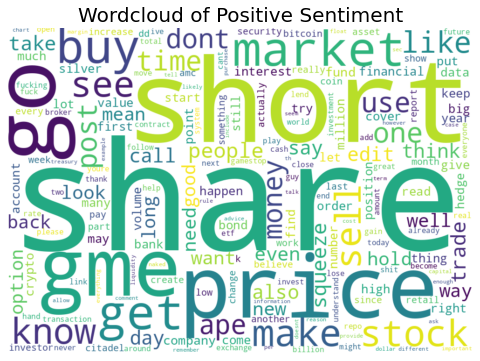

In [0]:
stopwords = nltk.corpus.stopwords.words('english')
pos_wordcloud = WordCloud(background_color="white", 
                          width=1000, height=700, stopwords=stopwords+['amp','ill','im','xb','gt'],
                         collocations=False)\
                .generate(' '.join(pos10000.clean_text))
 
plt.figure(figsize=(9,6))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.title("Wordcloud of Positive Sentiment", fontsize=20)
plt.axis('off')
plt.savefig("../../data/plots/positive_wordcloud.png")
plt.show()

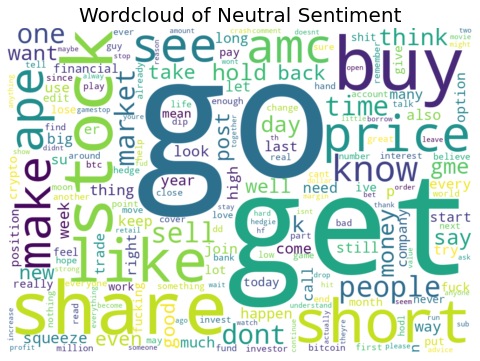

In [0]:
neu_wordcloud = WordCloud(background_color="white", 
                          width=1000, height=700, stopwords=stopwords+['amp','ill','im','xb','gt'],
                         collocations=False)\
                .generate(' '.join(neu10000.clean_text))
 
plt.figure(figsize=(9,6))
plt.imshow(neu_wordcloud, interpolation='bilinear')
plt.title("Wordcloud of Neutral Sentiment", fontsize=20)
plt.axis('off')
plt.savefig("../../data/plots/neutral_wordcloud.png")
plt.show()

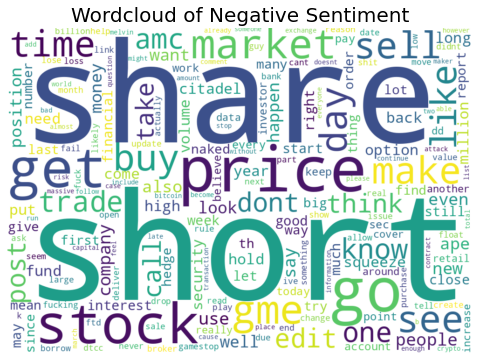

In [0]:
neg_wordcloud = WordCloud(background_color="white", 
                          width=1000, height=700, stopwords=stopwords+['amp','ill','im','xb','gt'],
                         collocations=False)\
                .generate(' '.join(neg10000.clean_text))
 
plt.figure(figsize=(9,6))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.title("Wordcloud of Negative Sentiment", fontsize=20)
plt.axis('off')
plt.savefig("../../data/plots/negative_wordcloud.png")
plt.show()